In [1]:
# Import standard packages
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Import Data
df = pd.read_csv("/Users/ad/Documents/Exercises/_RgressionModeling/data/signage2015_kloof_seapoint.csv")
df.head()

,sign,Illuminated,Height,Width,Area,longitude,latitude,Suburb,illum
0,flatsgn,1,20.0,15.0,300.00,18.413518,-33.927335,Gardens,Yes
1,flatsgn,1,1.0,1.0,1.00,18.413378,-33.927435,Gardens,Yes
2,flatsgn,1,15.0,10.0,150.00,18.413138,-33.927596,Gardens,Yes
3,flatsgn,1,0.3,4.0,1.20,18.412546,-33.928151,Gardens,Yes
4,flatsgn,0,0.5,1.5,0.75,18.412608,-33.928158,Gardens,No


In [13]:
df.columns

Index(['sign', 'Illuminated', 'Height', 'Width', 'Area', 'longitude',
       'latitude', 'Suburb', 'illum', 'logHeight', 'logWidth', 'logArea'],
      dtype='object')

# Descriptive Statitstics

In [29]:
# Calculate the logDimension and append frame with logValue
def calcLog(dimension): 
    var = 'log'+ dimension
    if var in df.columns: # Check if column exist in df
        return var
    else:
        df[var] = np.log(df[dimension]+1)
        return var
    
def reset_df():
    return df[['sign', 'Illuminated', 'Height', 
               'Width', 'Area', 'longitude', 
               'latitude', 'Suburb', 'illum']]

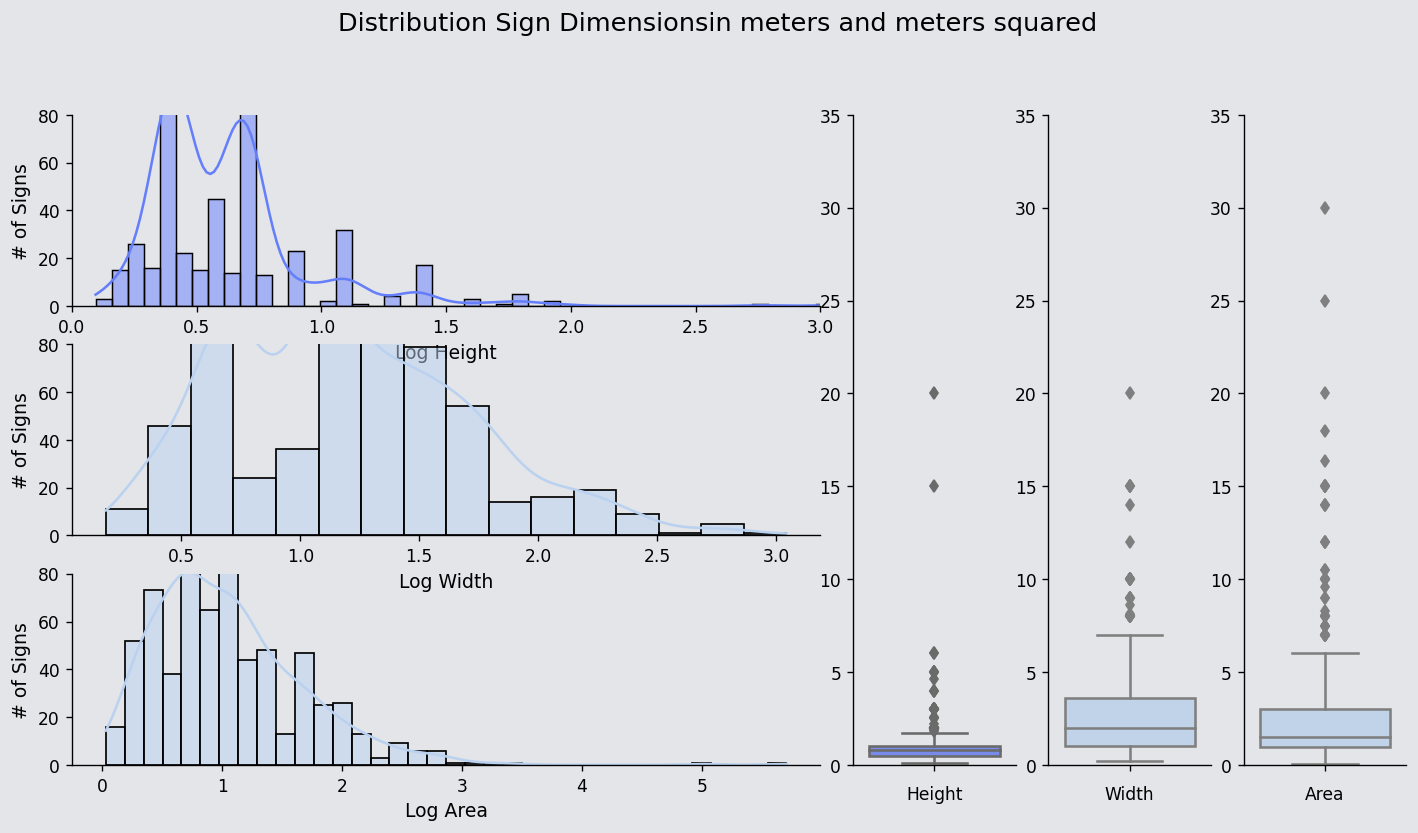

In [30]:
fig = plt.figure(figsize=(14, 7), dpi=123, facecolor='#E4E5E9') # Generate the figure
spec = fig.add_gridspec(ncols=7, nrows=3)

# Configure Distribution Plots
g0 = fig.add_subplot(spec[0, :4])
sns.histplot(df[calcLog('Height')], kde=True, color='#657FFB', edgecolor='black') #kde - kernal density estimate
#sns.histplot(x='Height', data=df, kde=True, color='#657FFB', edgecolor='black') 
plt.ylabel('# of Signs', fontsize=11)
plt.xlabel('Log Height', fontsize=11)
plt.xlim(0, 3)
plt.ylim(0, 80)

g1 = fig.add_subplot(spec[1, :4])
sns.histplot(df[calcLog('Width')], kde=True, color='#BAD2EF', edgecolor='black') 
#sns.histplot(x='Width', data=df, kde=True, color='#BAD2EF', edgecolor='black')
plt.ylabel('# of Signs', fontsize=11)
plt.xlabel('Log Width', fontsize=11)
#plt.xlim(0, 20)
plt.ylim(0, 80)

g2 = fig.add_subplot(spec[2, :4])
sns.histplot(df[calcLog('Area')], kde=True, color='#BAD2EF', edgecolor='black') 
#sns.histplot(x='Area', data=df, kde=True, color='#BAD2EF', edgecolor='black')
plt.ylabel('# of Signs', fontsize=11)
plt.xlabel('Log Area', fontsize=11)
#plt.xlim(0, 20)
plt.ylim(0, 80)

# Configure Box Plots
g3 = fig.add_subplot(spec[:, 4])
sns.boxplot(y=df['Height'], color='#657FFB')
plt.xlabel('Height', labelpad=5, fontsize=10)
plt.ylabel(' ')
plt.ylim(0, 35)

g4 = fig.add_subplot(spec[:, 5])
sns.boxplot(y=df['Width'], color='#BAD2EF')
plt.xlabel('Width', labelpad=5, fontsize=10)
plt.ylabel(' ')
plt.ylim(0, 35)

g5 = fig.add_subplot(spec[:, 6])
sns.boxplot(y=df['Area'], color='#BAD2EF')
plt.xlabel('Area', labelpad=5, fontsize=10)
plt.ylabel(' ')
plt.ylim(0, 35)

for g in [g0, g1, g2, g3, g4, g5]:
    g.patch.set_alpha(0.0)
    g.spines['top'].set_visible(False)
    g.spines['right'].set_visible(False)
    
fig.suptitle('Distribution Sign Dimensionsin meters and meters squared', fontsize=15, y=1)
plt.show()

df = reset_df()

In [37]:
# Obtain descriptive statics of continous variables
df[['Height','Width', 'Area']].describe().round(3)

,Height,Width,Area
count,720.000,720.000,720.000
mean,0.959,2.754,3.101
std,1.146,2.333,12.719
min,0.100,0.200,0.030
25%,0.500,1.000,0.960
50%,0.800,2.000,1.500
75%,1.000,3.600,3.000
max,20.000,20.000,300.000


# Feature Engineering

The data is multivariate containing continous and categorical variables. Further, 'illum' maps 'Illuminated', hence only one of these are needed, noting that the variables represent a qualitative property, i.e., whether a sign is of type illuminated. Other categorical variables are 'Suburb' and 'sign'. Illuminated signs are a sub-category of sign. 

The sign dimension (i.e., Area, Height, and Width) are measured in meters sqaured and meter scales, respectively. From the box plots and the frequency distributions, the continuous variables (Height, Width, and Area) are skewed to the right, and several outliers beset the data. However, rather than a measurement error, these are outsized signs. 

## Transform (or Scale) Data

Although some machine learning algorithms (e.g., neural networks and SVM's) are sensitive to outliers and non-normally distributed data (Müller et al., 2017, p. 132), or others (e.g., K-means and K-Nearest Neighbors) that are sensitive to the scale of the numeric feature, requiring the data to be transformed, in the main, machine learning algorithms learn the distribution embedded within the features themselves (Mueller et al., 2016, p. 226). According to Mueller (2016), transforming the data nonetheless allows for faster algortihm convergence and minimises prediction error.

One way to addresss the above points outside the interquartile range is to use a scaling method impervious to outliers. RobustScaler, as the name suggest, use statistics that are robust to outliers (Pedregosa et al., JMLR 12, pp. 2825-2830, 2011; Buitinck et al., 2013).  

In [57]:
# Scale continous variables, except coordinates (lat, long)
features_to_scale = ['Width', 'Height', 'Area']
dat_to_scale = df[features_to_scale]

# RobustScaler's desensitised to outliers
from sklearn.preprocessing import RobustScaler

robust_scale = RobustScaler()
robust_scale.fit(dat_to_scale)

dat_to_scale = robust_scale.transform(dat_to_scale)

In [62]:
dat_to_scale = pd.DataFrame(dat_to_scale, columns=features_to_scale)
dat_to_scale.head()

df_scaled = df
df_scaled = df_scaled.assign(Width=dat_to_scale['Width'])
df_scaled = df_scaled.assign(Height=dat_to_scale['Height'])
df_scaled = df_scaled.assign(Area=dat_to_scale['Area'])

,sign,Illuminated,Height,Width,Area,longitude,latitude,Suburb,illum
0,flatsgn,1,38.4,5.000000,146.323529,18.413518,-33.927335,Gardens,Yes
1,flatsgn,1,0.4,-0.384615,-0.245098,18.413378,-33.927435,Gardens,Yes
2,flatsgn,1,28.4,3.076923,72.794118,18.413138,-33.927596,Gardens,Yes
3,flatsgn,1,-1.0,0.769231,-0.147059,18.412546,-33.928151,Gardens,Yes
4,flatsgn,0,-0.6,-0.192308,-0.367647,18.412608,-33.928158,Gardens,No
...,...,...,...,...,...,...,...,...,...
715,cnopy,1,-0.4,-0.384615,-0.441176,18.382569,-33.921528,Seapoint,Yes
716,cnopy,1,-0.4,-0.384615,-0.441176,18.382567,-33.921536,Seapoint,Yes
717,cnopy,1,0.4,0.000000,0.245098,18.382518,-33.921482,Seapoint,Yes
718,cnopy,1,0.4,0.000000,0.245098,18.382386,-33.921531,Seapoint,Yes


In [66]:
# Instantiate dataframe
#X_train_scale = X_train

# Reassign transformed values to X_train
#X_train_scale = X_train_scale.assign(Width=dat_to_scale[:, 0], 
#                               Height=dat_to_scale[:, 1],
#                               Area=dat_to_scale[:, 2])

# Repeat for test sample
#dat_to_scale = X_test[features_to_scale]
#dat_to_scale = robust_scale.transform(dat_to_scale) 

#X_test_scale = X_test
#X_test_scale = X_test_scale.assign(Width=dat_to_scale[:, 0],
#                                   Height=dat_to_scale[:, 1],
#                                   Area=dat_to_scale[:, 2])

## One Hot Enconding

For classification algorithms, one feature for each qualitative ascription is prefered (Müller et al., 2017). This is achieved by the one-hot-encoding.

In [82]:
# Ferret out the needed columns
feature_col = ['Suburb', 'sign', 'illum', 'Width', 'Height', 'Area', 'latitude', 'longitude']

# One-Hot-Encoding
df_onehot = pd.get_dummies(df_scaled[feature_col])

# Ferret out new variable names
feature_col_onehot = df_onehot.loc[:, 'Width':'sign_projctng'].columns

df_onehot.head()

,Width,Height,Area,latitude,longitude,Suburb_Gardens,Suburb_Seapoint,sign_bndrywll,sign_cnopy,sign_flatsgn,sign_projctng,illum_No,illum_Yes
0,5.000000,38.4,146.323529,-33.927335,18.413518,1,0,0,0,1,0,0,1
1,-0.384615,0.4,-0.245098,-33.927435,18.413378,1,0,0,0,1,0,0,1
2,3.076923,28.4,72.794118,-33.927596,18.413138,1,0,0,0,1,0,0,1
3,0.769231,-1.0,-0.147059,-33.928151,18.412546,1,0,0,0,1,0,0,1
4,-0.192308,-0.6,-0.367647,-33.928158,18.412608,1,0,0,0,1,0,1,0


## Partition train and test samples

In [83]:
# Feature (X) and target (y) extraction
X = df_onehot[feature_col_onehot] # Features
y = df_onehot['illum_Yes'] # Target variable

In [84]:
# Partition train and test samples
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.25, random_state=0)

In [88]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0, max_depth=7)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree, X, y, cv=11, scoring='f1')
print(scores)
print(
    "\n%0.3f accuracy with a standard deviation of %0.3f" 
    % (scores.mean(), scores.std())
)

[0.55       0.17142857 0.07142857 0.4057971  0.18518519 0.38461538
 0.66666667 0.61764706 0.67647059 0.59649123 0.56716418]

0.445 accuracy with a standard deviation of 0.206


In [77]:
tree = DecisionTreeClassifier(random_state=0, max_depth=7).fit(X_train, y_train)
# tree = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
y_pred = tree.predict(X_test)

print("Confusion Matrix: \n", format(confusion_matrix(y_test, y_pred)))
print("\nAccuracy Score:", format(accuracy_score(y_test, y_pred)))
print("\nClassificatin Report:\n", format(classification_report(y_test, y_pred)))
print("Training set score: {:.3f}".format(tree.score(X_train, y_train)))
print("\nTest set score: {:.3f}".format(tree.score(X_test, y_test)))

Confusion Matrix: 
 [[54 25]
 [56 45]]

Accuracy Score: 0.55

Classificatin Report:
               precision    recall  f1-score   support

           0       0.49      0.68      0.57        79
           1       0.64      0.45      0.53       101

    accuracy                           0.55       180
   macro avg       0.57      0.56      0.55       180
weighted avg       0.58      0.55      0.55       180

Training set score: 0.743

Test set score: 0.550


 ## Feature Selection

In [71]:
correlation_matrix = X.corr()
print('Correlation Matrix: \n{}'.format(correlation_matrix))

Correlation Matrix: 
                    Width    Height      Area  Suburb_Gardens  \
Width            1.000000  0.172111  0.389670       -0.048323   
Height           0.172111  1.000000  0.812908        0.056877   
Area             0.389670  0.812908  1.000000        0.068257   
Suburb_Gardens  -0.048323  0.056877  0.068257        1.000000   
Suburb_Seapoint  0.048323 -0.056877 -0.068257       -1.000000   
sign_bndrywll   -0.119111  0.071903 -0.014578        0.152632   
sign_cnopy      -0.090717 -0.168430 -0.086788        0.081453   
sign_flatsgn     0.314270  0.093935  0.137020       -0.146421   
sign_projctng   -0.221123  0.071043 -0.051289        0.000570   

                 Suburb_Seapoint  sign_bndrywll  sign_cnopy  sign_flatsgn  \
Width                   0.048323      -0.119111   -0.090717      0.314270   
Height                 -0.056877       0.071903   -0.168430      0.093935   
Area                   -0.068257      -0.014578   -0.086788      0.137020   
Suburb_Gardens      

<AxesSubplot:>

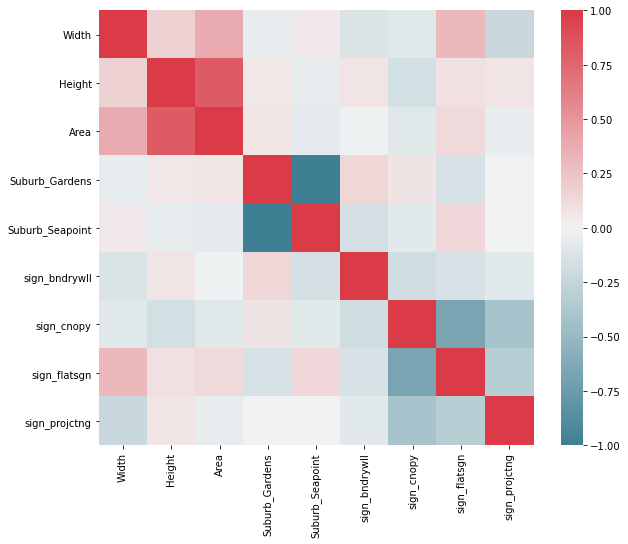

In [72]:
import seaborn as sns
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=np.zeros_like(correlation_matrix, dtype=np.bool),
           cmap=sns.diverging_palette(220, 10, as_cmap=True),
           square=True, ax=ax)

Starting off at the sign dimentions, we find that 
- area has a higher correlation with height (0.813) than width (0.390); 
- compared to the four sign types (i.e., flat-, boundary-, canopy-, and projecting signs) Area has a higher correlation with flat signs (0.137), as does height (0.094) and width (0.314); 
- finally, of the three sign dimensions, area has a higher correlation with illuminated sign (0.060). 

Illuminated signs have a higher correlation with flat signs (0.057). Whereas Gardens have a higher correlation with boundary wall signs(0.153), Seapoint has a higher correlation with flat signs (0.146).
Interestingly, while all signs are negatively correlated, flat sign have the greatest negative correlation with canopy sign (-0.666). A possible reason for this could be where there is no canopy over the pavement, eliminating the choice of suspending a sign from the canopy; flatsigns being the next best option. Here building dimensionality is a case in point for determining sign choice. 

From the above, Features with an absolute correlation greater 0.5 threshold were selected. These

In [74]:
correlated_feature_matrix = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.6:
            corr_col = correlation_matrix.columns[i]
            correlated_feature_matrix.add(corr_col)

            
print(correlated_feature_matrix)

{'Suburb_Seapoint', 'sign_flatsgn', 'Area'}


# Classifiers

## Logistic Regression 

### Without Transformed Data

In [9]:
# Logistic Regression with one-hot-encoded data
logreg = LogisticRegression().fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print("Confusion Matrix: \n", format(confusion_matrix(y_test, y_pred)))
print("\nAccuracy Score: {:.3f}".format(accuracy_score(y_test, y_pred)))
print("\nClassificatin Report:\n", format(classification_report(y_test, y_pred)))
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("\nTest set score: {:.3f}".format(logreg.score(X_test, y_test)))

Confusion Matrix: 
 [[59 20]
 [65 36]]

Accuracy Score: 0.528

Classificatin Report:
               precision    recall  f1-score   support

           0       0.48      0.75      0.58        79
           1       0.64      0.36      0.46       101

    accuracy                           0.53       180
   macro avg       0.56      0.55      0.52       180
weighted avg       0.57      0.53      0.51       180

Training set score: 0.593

Test set score: 0.528


From the confusion matrix we can conclude that:
- the number of signs correctly classified as illuminated is 36 (i.e., True Positive);
- the number of signs correctly classified as un-illimunated is 59 (i.e., True Negative);
- the number of un-illuminated signs classified as illuminated is 20 (i.e., False Positive);
- and the number of illuminated signs wrongly classified as un-illuminated is 65 (i.e., False Negative)

Accuracy Score = Correct Predictions / Total Predictions. Or the number of successfull predictions:
(True Positives + True Negatives) / (Total in test sample) = (36 + 59) / (0.25 * 720) = 0.528

Recall Score (or true positive rate) = Percentage of illuminated signs identified correctly:
(True Positive) / (True Positve + False Negative) = 36 / (36 + 65) = 0.356

Precision Score = Percentage of signs identified as illuminated that are actually illuminated:
(True Positive) / (True Positive + False Positive) = 36 / (36 + 20) = 0.643

### With Transformed Data

In [10]:
logreg_scaled = LogisticRegression().fit(X_train_scale, y_train)
y_pred = logreg_scaled.predict(X_test_scale)

print("Confusion Matrix: \n", format(confusion_matrix(y_test, y_pred)))
print("\nAccuracy Score:", format(accuracy_score(y_test, y_pred)))
print("\nClassificatin Report:\n", format(classification_report(y_test, y_pred)))
print("Training set score: {:.3f}".format(logreg_scaled.score(X_train_scale, y_train)))
print("\nTest set score: {:.3f}".format(logreg_scaled.score(X_test_scale, y_test)))

Confusion Matrix: 
 [[60 19]
 [65 36]]

Accuracy Score: 0.5333333333333333

Classificatin Report:
               precision    recall  f1-score   support

           0       0.48      0.76      0.59        79
           1       0.65      0.36      0.46       101

    accuracy                           0.53       180
   macro avg       0.57      0.56      0.52       180
weighted avg       0.58      0.53      0.52       180

Training set score: 0.591

Test set score: 0.533


The transformed data delivers slightly better training- and test set scores. However, the recall metric is below desired. As corroborated by the false negative count (i.e., 65), a large proportion of illuminated signs are wrongly classified.  

### Precision-Recall

Assuming that an illuminated sign comes at premium, a lower recall is undesirable say for a cost estimate. One way to adjust the tradeoff between recall and precision is to adjust the threshold at which the model makes the classification decision (Müller et al., 2017, p. 289). 

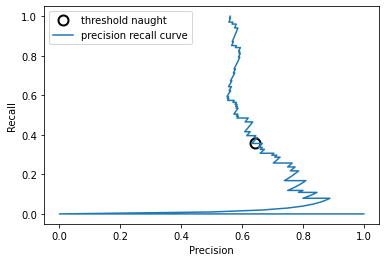

In [11]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(precision, recall, thresholds, threslabel):
    # Find Threshold closest to zero
    close_zero = np.argmin(np.abs(thresholds))
    plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
        label = threslabel, fillstyle='none', c='k', mew=2)

    plt.plot(precision, recall, label='precision recall curve')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.legend(loc=2)

precision, recall, thresholds = precision_recall_curve(y_test, logreg_scaled.decision_function(X_test_scale))
plot_precision_recall_curve(precision, recall, thresholds, 'threshold naught')

The `decision_function`'s default threshold is 0—that is the black circle in the *Precision-Recall* graph above—corresponding to 0.64 precision and 0.356 recall. The steep gradient at the beginning, between recall equalling 1 and 0.4, suggest that gain in precision sacrifices plenty recall. On the whole the model has low recall retention as precision increases. Prefered in this case is that recall is kept high as precision increases. That is, a graph that veers toward the upper-right corner, rather than (in the above case) one that recedes there-from (Müller et al., 2017, p. 290).  

Given the graph's naught threshold position (with increasing threshold from left to right), setting the *operating-point* to increase recall would mean reducing the threshold below naught—i.e., shift the threshold point to the left.

              precision    recall  f1-score   support

           0       0.67      0.10      0.18        79
           1       0.58      0.96      0.72       101

    accuracy                           0.58       180
   macro avg       0.62      0.53      0.45       180
weighted avg       0.62      0.58      0.48       180


Confusion Matrix: 
 [[ 8 71]
 [ 4 97]]

Average precision 0.577


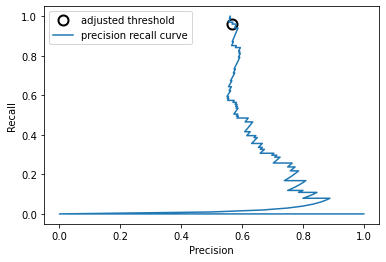

In [12]:
# Reduce the threshold below naught
y_pred_lower_threshold = logreg_scaled.decision_function(X_test_scale) > -0.8
print(classification_report(y_test, y_pred_lower_threshold))

print("\nConfusion Matrix: \n", format(confusion_matrix(y_test, y_pred_lower_threshold)))

from sklearn.metrics import average_precision_score
print("\nAverage precision {:.3f}".format(average_precision_score(y_test, y_pred_lower_threshold)))

plot_precision_recall_curve(precision, recall, y_pred_lower_threshold, 'adjusted threshold')

Although adjusting the threshold yields significant recall improvement (from 0.36 to 0.96 in the above graph), slightly decreasing precision (from 0.65 to 0.58), the number of false positives shot up (from 19 to 71). Further, the average precision—i.e., the area under the precision-recall curve—totals 0.577. This  is slightly off the midrange mark (0.5) for average precision (Müller et al., 2017, p. 292). For this reason, it's concluded that the model has average precsion.   

Precision and recall are important meausures for determining model success, not least for 'class-imbalenced problems' (Chollet, 2018, p. 112). For 'balanced classification problems' the *receiver operating characteristc* (ROC) and *area under the curve* (AUC) metric are recommended. Before calculating these, class imbalance occur when 'one class is more frequent than the other', also called an imbalanced data set (Müller et al., 2017, p. 277). In this example the number of illuminated signs relatively equal the un-illuminated signs (352 illuminated out of 720 signs), suggesting that the ROC and AUC metric are better measures of model success (Chollet, 2018, p. 112).   

In [13]:
df_onehot['illum_Yes'].value_counts()

0    368
1    352
Name: illum_Yes, dtype: int64

The ROC curve plots the *True Positive Rate* (TPR) or Recall on the y-axis against the *False Positive Rate* (FPR) on the x-axis at various thresholds. A suitable ROC curve yields high Recall and low FPR—a curve that traverses upwards from the origin toward the top left corner, petering out at the top right corner (Müller et al., 2017, p. 293). The AUC is the area under the ROC curve,  thus:   

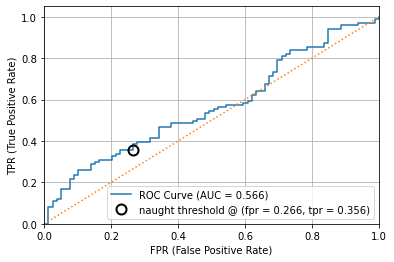

In [83]:
from sklearn.metrics import roc_auc_score
logreg_auc = roc_auc_score(y_test, logreg_scaled.decision_function(X_test_scale))

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, logreg_scaled.decision_function(X_test_scale))

def plot_custom_roc(fpr, tpr, thresholds):
    plt.plot(fpr, tpr, label="ROC Curve (AUC = %0.3f)" % logreg_auc)
    plt.xlabel("FPR (False Positive Rate)")
    plt.ylabel("TPR (True Positive Rate)")
    
    # Find threshold closest to zero
    close_zero = np.argmin(np.abs(thresholds))
    plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label = 'naught threshold @ (fpr = %0.3f, ' % fpr[close_zero] + 'tpr = %0.3f)' % tpr[close_zero], 
         fillstyle='none', c='k', mew=2)
    
    plt.plot([0, 1], linestyle=":")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid(True)
    plt.legend(loc=4)

plot_custom_roc(fpr, tpr, thresholds)

In [39]:
dud = pd.DataFrame()
type(dud)

box = []
type(box)

list

The naught (or default) threshold positions at 0.266 FPR and 0.356 TPR. The AUC (0.566) suggest that there's 56.6% 'probability that a randomly picked point of the positive class will have a higher score according to the classifier than a randomly picked point from the negative class' (Müller et al., 2017, p. 295). Hence the classifier  predicts slighty better than a random-guess predictor with AUC = 0.5 (i.e., the area under the diagonal line).

### Cross-Validation

In [15]:
from sklearn.model_selection import cross_val_score

logreg_cross_val = LogisticRegression(max_iter=200).fit(X_train_scale, y_train)
scores = cross_val_score(logreg_cross_val, X_train_scale, 
                         y_train, cv=10, scoring='f1')
print(
    'Cross-validation scores (10 splits): \n {}'.format(scores)
)

print(
    "\n%0.3f accuracy with a standard deviation of %0.3f" 
    % (scores.mean(), scores.std())
)

#print('Cross Val Score: {}'.format(logreg_cross_val.score(X_test_scale, y_test)))
#print('Average cross-validation score: {:.3f}'.format(scores.mean()))

Cross-validation scores (10 splits): 
 [0.28571429 0.27906977 0.35       0.47619048 0.3125     0.41860465
 0.28571429 0.36842105 0.4        0.41025641]

0.359 accuracy with a standard deviation of 0.064


#### k-Fold Cross-Validation

In [16]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10)
scores = cross_val_score(logreg_cross_val, X_train_scale, 
                         y_train, cv=kfold, scoring='f1')
print('Cross-validation scores (10 splits): \n {}'.format(scores))
print(
    "\n%0.3f accuracy with a standard deviation of %0.3f" 
    % (scores.mean(), scores.std())
)
# print('\nAverage cross-validation score: {:.3f}'.format(scores.mean()))

Cross-validation scores (10 splits): 
 [0.28571429 0.33333333 0.35       0.37209302 0.4375     0.34146341
 0.23529412 0.51282051 0.57894737 0.41025641]

0.386 accuracy with a standard deviation of 0.098


#### Repeated k-Fold Cross-Validation

In [17]:
from sklearn.model_selection import RepeatedKFold
repeated_kfold = RepeatedKFold(n_splits=10, n_repeats=2)
scores = cross_val_score(logreg_cross_val, X_train_scale, 
                         y_train, cv=repeated_kfold, scoring='f1')
print('Cross-validation scores (10 splits): \n {}'.format(scores))
print(
    "\n%0.3f accuracy with a standard deviation of %0.3f" 
    % (scores.mean(), scores.std())
)
# print('\nAverage cross-validation score: {:.3f}'.format(scores.mean()))

Cross-validation scores (10 splits): 
 [0.41025641 0.35294118 0.38888889 0.27906977 0.45       0.45
 0.30769231 0.28571429 0.4        0.22857143 0.29268293 0.36842105
 0.42105263 0.29166667 0.46153846 0.5        0.33333333 0.52380952
 0.3902439  0.27777778]

0.371 accuracy with a standard deviation of 0.080


#### Shuffle k-Fold Cross-Validation

In [18]:
kfold_shuffle = KFold(n_splits=10, shuffle=True, random_state=0)
scores = cross_val_score(logreg_cross_val, X_train_scale, 
                         y_train, cv=kfold_shuffle, scoring='f1')
print('\nCross-validation scores (10 splits, shuffle=True, random_state=0): \n {}'.format(scores))
print(
    "\n%0.3f accuracy with a standard deviation of %0.3f" 
    % (scores.mean(), scores.std())
)

print('\nAverage cross-validation score: {:.3f}'.format(scores.mean()))


Cross-validation scores (10 splits, shuffle=True, random_state=0): 
 [0.52631579 0.15789474 0.46511628 0.51282051 0.30769231 0.36842105
 0.48648649 0.38095238 0.41860465 0.48979592]

0.411 accuracy with a standard deviation of 0.108

Average cross-validation score: 0.411


In [19]:
from sklearn.model_selection import ShuffleSplit
shuffle_split = ShuffleSplit(n_splits=10, random_state=0)
scores = cross_val_score(logreg_cross_val, X_train_scale, 
                         y_train, cv=shuffle_split, scoring='f1')
print('\nCross-validation scores (10 splits, shuffle=True, random_state=0): \n {}'.format(scores))
print(
    "\n%0.3f accuracy with a standard deviation of %0.3f" 
    % (scores.mean(), scores.std())
)

print('\nAverage cross-validation score: {:.3f}'.format(scores.mean()))


Cross-validation scores (10 splits, shuffle=True, random_state=0): 
 [0.52631579 0.47619048 0.41025641 0.4        0.3        0.4
 0.41666667 0.25641026 0.35897436 0.44897959]

0.399 accuracy with a standard deviation of 0.075

Average cross-validation score: 0.399


#### Stratified k-Fold Cross-Validation

In [20]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

scores = cross_val_score(logreg_cross_val, X_train_scale, 
                         y_train, cv=skf, scoring='f1')
print('\nStratifiedKFold Cross-validation scores (10 splits, shuffle=True, random_state=0): \n {}'.format(scores))
print(
    "\n%0.3f accuracy with a standard deviation of %0.3f" 
    % (scores.mean(), scores.std())
)

print('\nAverage cross-validation score: {:.3f}'.format(scores.mean()))


StratifiedKFold Cross-validation scores (10 splits, shuffle=True, random_state=0): 
 [0.41176471 0.47619048 0.51162791 0.42105263 0.28571429 0.37837838
 0.42105263 0.43902439 0.46153846 0.26666667]

0.407 accuracy with a standard deviation of 0.074

Average cross-validation score: 0.407


## Decision Trees Classifier

In [82]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0, max_depth=7).fit(X_train, y_train)
# tree = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
y_pred = tree.predict(X_test)

print("Confusion Matrix: \n", format(confusion_matrix(y_test, y_pred)))
print("\nAccuracy Score:", format(accuracy_score(y_test, y_pred)))
print("\nClassificatin Report:\n", format(classification_report(y_test, y_pred)))
print("Training set score: {:.3f}".format(tree.score(X_train, y_train)))
print("\nTest set score: {:.3f}".format(tree.score(X_test, y_test)))

Confusion Matrix: 
 [[61 18]
 [44 57]]

Accuracy Score: 0.6555555555555556

Classificatin Report:
               precision    recall  f1-score   support

           0       0.58      0.77      0.66        79
           1       0.76      0.56      0.65       101

    accuracy                           0.66       180
   macro avg       0.67      0.67      0.66       180
weighted avg       0.68      0.66      0.65       180

Training set score: 0.813

Test set score: 0.656


AttributeError: 'DecisionTreeClassifier' object has no attribute 'decision_function'

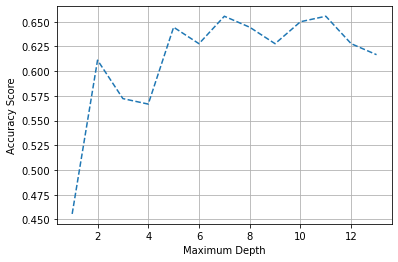

In [87]:
from sklearn.metrics import r2_score
maxdepth = []
accuracy = []
for max_depth in range(1,14):
    tree = DecisionTreeClassifier(random_state=0, max_depth=max_depth).fit(X_train_scale, y_train)
    predict = tree.predict(X_test_scale)
    maxdepth.append(max_depth)
    accuracy.append(accuracy_score(y_test, predict))
    #print("max_depth {}, accuracy {:.3f}".format(max_depth, accuracy_score(y_test, predict)))

plt.plot(maxdepth, accuracy, linestyle="--")
plt.xlabel("Maximum Depth")
plt.ylabel("Accuracy Score")
plt.grid(True)

fpr, tpr, thresholds = roc_curve(y_test, tree.decision_function(X_test_scale))
plot_custom_roc(fpr, tpr, thresholds)

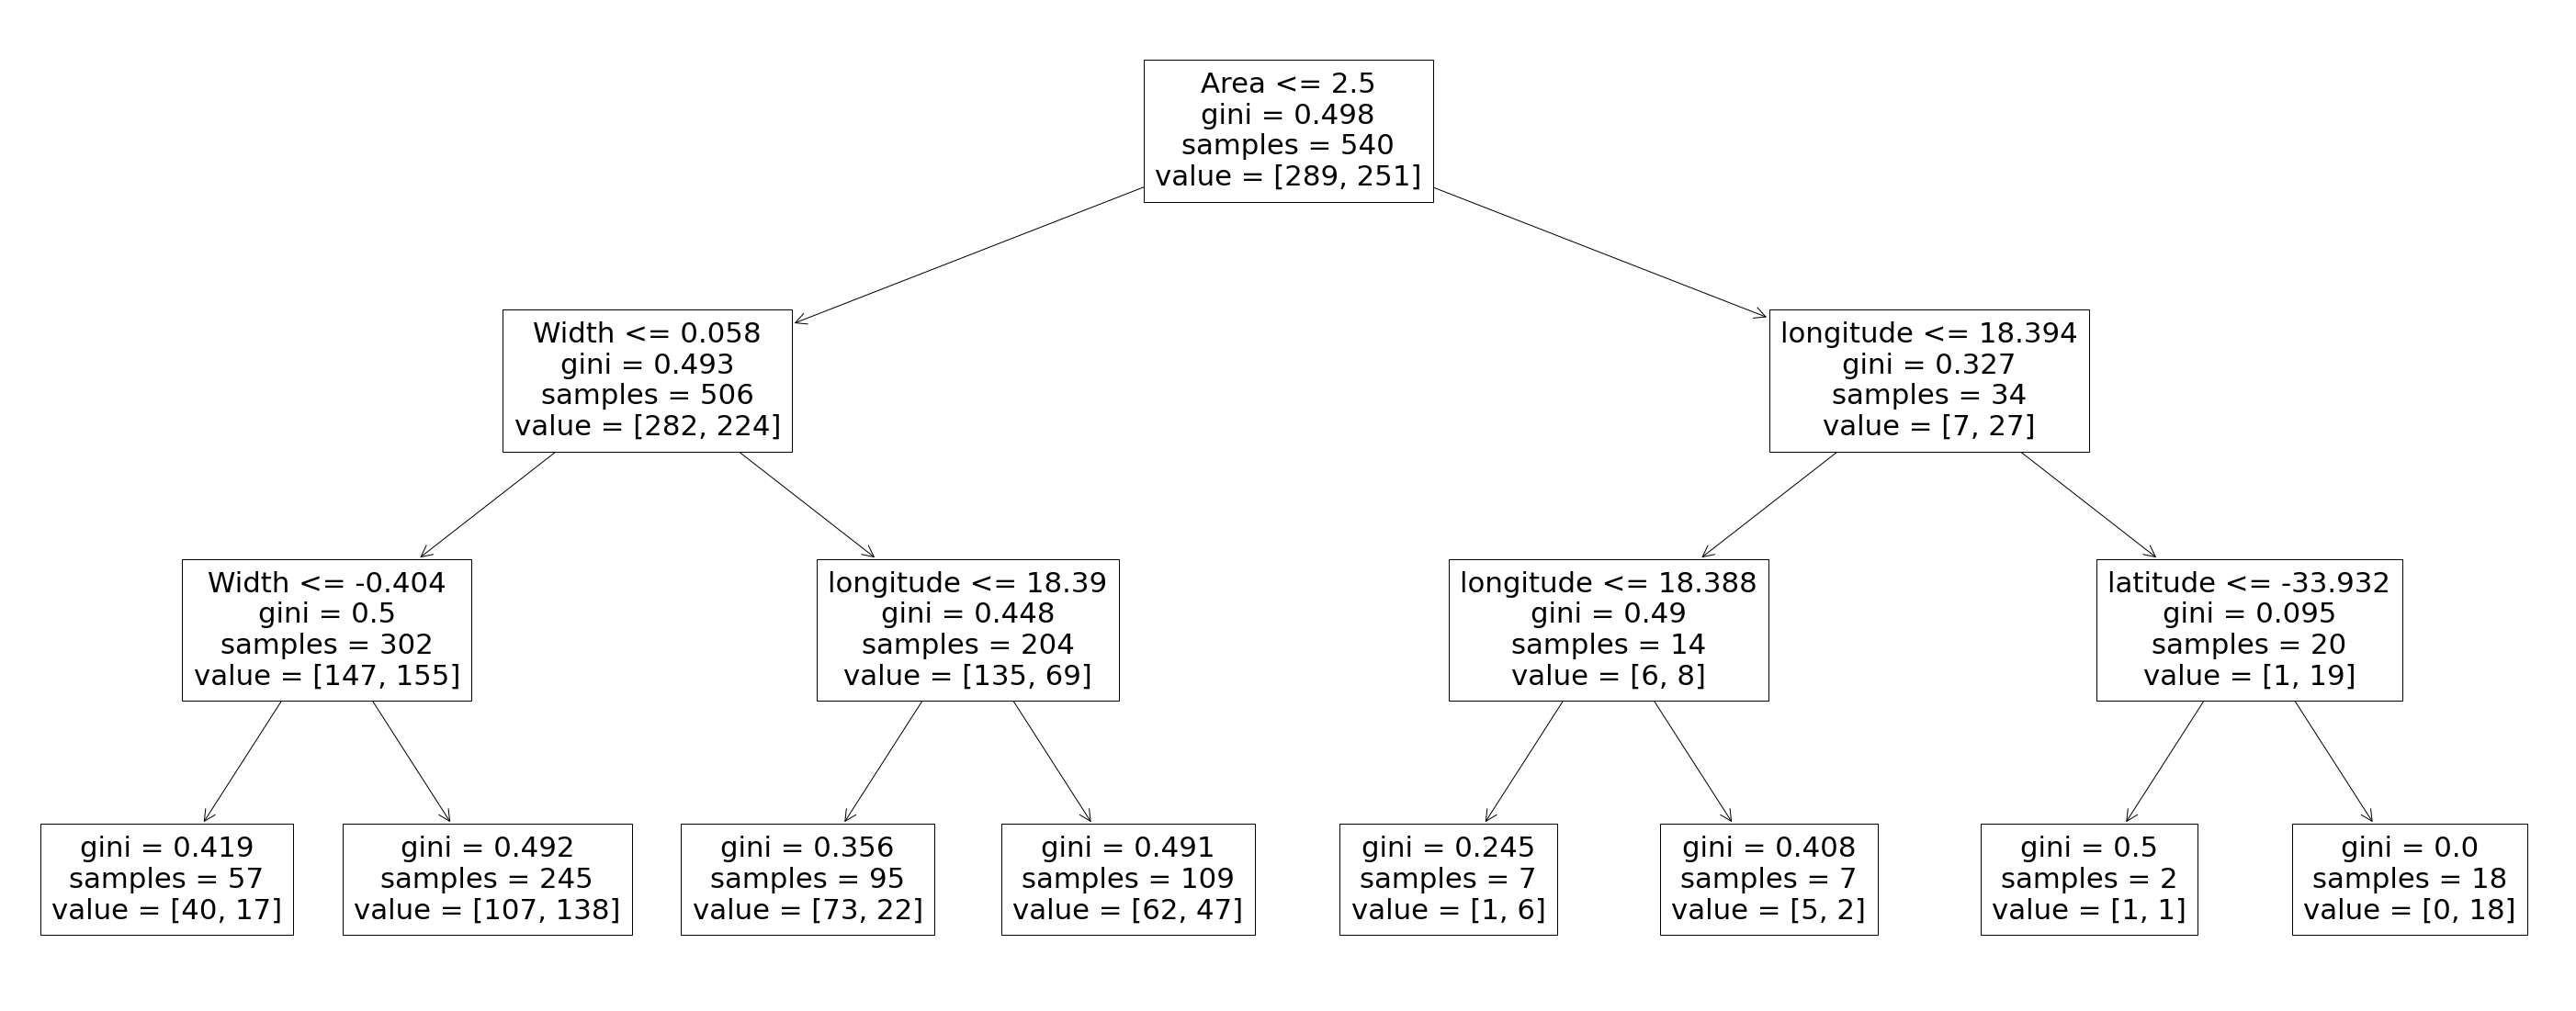

In [88]:
from sklearn import tree

tree_model = DecisionTreeClassifier(random_state=0, max_depth=3).fit(X_train_scale, y_train)

plt.figure(figsize=(50,20))
tree.plot_tree(tree_model, feature_names=X_train_scale.columns)
plt.show()

### Feature Importance

In [62]:
plt.plot(logreg.coef_.T, 'o', label="C=1")
plt.plot(logreg.fit(.coef_.T, '^', label="C=100")
plt.xticks(range(X.shape[1]), feature_cols_onehot, rotation=90)
plt.hlines(0, 0, X.shape[1])
plt.ylim(-5, 5)
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
plt.title("Coefieicients learned by logistic regression with L2 penalty for different C values, where C is the strength regularisation")
plt.legend()

SyntaxError: invalid syntax (<ipython-input-62-0dff57e03fae>, line 2)

In [ ]:
for var, coef in zip(feature_cols, 
                    logreg.coef_[0]):
    print('%7s : %7.3f' %(var, coef))

In [ ]:
def plot_feature_importance(model):
    n_features = X.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), feature_cols)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
plot_feature_importance(tree)

# Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Build 5 trees
forest = RandomForestClassifier(n_estimators=10, 
                                max_features="sqrt", 
                                max_depth=None, 
                                min_samples_split=2,
                                bootstrap=True)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

print("Confusion Matrix: \n", format(confusion_matrix(y_test, y_pred)))
print("\nAccuracy Score:", format(accuracy_score(y_test, y_pred)))
print("\nClassificatin Report:\n", format(classification_report(y_test, y_pred)))
print("Training set score: {:.3f}".format(forest.score(X_train, y_train)))
print("\nTest set score: {:.3f}".format(forest.score(X_test, y_test)))

plot_feature_importance(forest)

In [ ]:
import mglearn
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(X_train, y_train, tree, ax=ax)

mglearn.plots.plot_2d_seperator(forest, X_train, fill=True, ax=axes[-1, -1],
                               alpha=.4)
axes[-1, -1].set_title("Random Forest")
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)